In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d yuvrajsinhachowdhury/herlev-dataset

Dataset URL: https://www.kaggle.com/datasets/yuvrajsinhachowdhury/herlev-dataset
License(s): unknown
 88% 36.0M/40.7M [00:00<00:00, 35.3MB/s]
100% 40.7M/40.7M [00:00<00:00, 47.7MB/s]


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/herlev-dataset.zip','r') as zip:
  zip.extractall('/content')

In [ ]:
X_train = []
y_train = []
image_size = 150
labels = ['carcinoma_in_situ','light_dysplastic','moderate_dysplastic','normal_columnar','normal_intermediate','normal_superficiel','severe_dysplastic']
for i in labels:
    folderPath = os.path.join('/content/Herlev Dataset/train',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/Herlev Dataset/test',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
len(y_train)

917

In [ ]:
classes=['carcinoma_in_situ','light_dysplastic','moderate_dysplastic','normal_columnar','normal_intermediate','normal_superficiel','severe_dysplastic']

In [ ]:
X_train,y_train=shuffle(X_train,y_train,random_state=1)
X_train.shape

(917, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=.1,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
images_dict = dict()
x_train_dict=dict()
for i, l in enumerate(y_train_new):
  if len(images_dict)==7:
    break
  if l not in images_dict.keys():
    x_train_dict[l] = X_train[i]
    images_dict[l] = X_train[i].reshape((150, 150,3))
images_dict = dict(sorted(images_dict.items()))
x_trian_each_class = [x_train_dict[i] for i in sorted(x_train_dict)]
x_train_each_class = np.asarray(x_trian_each_class)

# example image for each class for test set
X_test_dict = dict()
for i, l in enumerate(y_test_new):
  if len(X_test_dict)==7:
    break
  if l not in X_test_dict.keys():
    X_test_dict[l] = X_test[i]
# order by class
x_test_each_class = [X_test_dict[i] for i in sorted(X_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

In [ ]:
y_test

array([[0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
 

In [ ]:
def plot_sample(x,y,index):
  plt.figure(figsize=(15,2))
  plt.imshow(x[index])
  plt.xlabel(classes[y[index]])

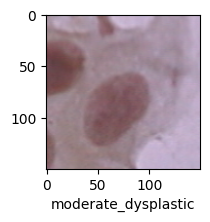

In [ ]:

plot_sample(X_train,y_train_new,0)

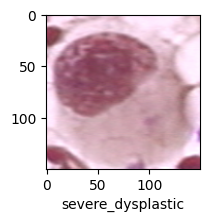

In [ ]:
plot_sample(X_train,y_train_new,6)

# **EfficientNetV2L**

In [ ]:
effnet = tf.keras.applications.EfficientNetV2L(weights='imagenet',include_top=False,input_shape=(150,150,3))

473176280/473176280 [==============================] - 5s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(7,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.Nadam(1e-3), metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("EVf.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
history = model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
26/26 [==============================] - ETA: 0s - loss: 1.3944 - accuracy: 0.4703
Epoch 1: val_accuracy improved from -inf to 0.54348, saving model to EVf.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 361s 2s/step - loss: 1.3944 - accuracy: 0.4703 - val_loss: 1.5208 - val_accuracy: 0.5435 - lr: 0.0010
Epoch 2/20
26/26 [==============================] - ETA: 0s - loss: 0.7861 - accuracy: 0.7164
Epoch 2: val_accuracy improved from 0.54348 to 0.55435, saving model to EVf.h5
26/26 [==============================] - 55s 2s/step - loss: 0.7861 - accuracy: 0.7164 - val_loss: 2.5012 - val_accuracy: 0.5543 - lr: 0.0010
Epoch 3/20
26/26 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.7576
Epoch 3: val_accuracy did not improve from 0.55435
26/26 [==============================] - 25s 955ms/step - loss: 0.6551 - accuracy: 0.7576 - val_loss: 1.4255 - val_accuracy: 0.5326 - lr: 0.0010
Epoch 4/20
26/26 [==============================] - ETA: 0s - loss: 0.4336 - accuracy: 0.8509
Epoch 4: val_accuracy improved from 0.55435 to 0.66304, saving model to EVf.h5
26/26 [==============================] - 53s 2s/step - loss: 0.4336 - accuracy:

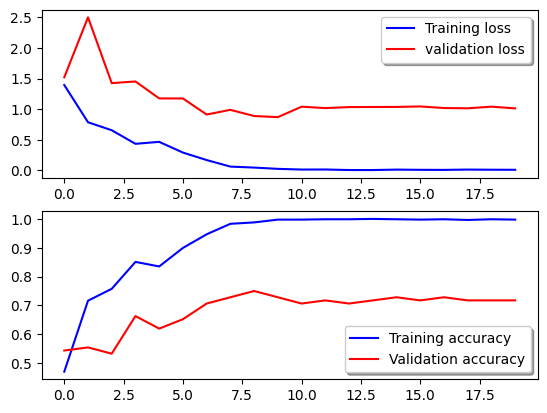

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.savefig("AUC.png")

predict

In [ ]:
Y_pred=model.predict(X_test)

3/3 [==============================] - 7s 220ms/step


In [ ]:
Y_pred[:5]

array([[4.5873167e-05, 7.3587328e-01, 2.6364502e-01, 2.2680676e-04,
        1.6726009e-04, 3.5868692e-05, 5.9078429e-06],
       [4.2505777e-03, 1.2599002e-02, 1.3609588e-02, 4.4679735e-04,
        1.2897434e-04, 3.8685362e-04, 9.6857822e-01],
       [4.2263642e-02, 3.9530481e-05, 2.7158023e-03, 5.5709854e-03,
        1.0897940e-04, 3.1735250e-04, 9.4898373e-01],
       [8.0738438e-04, 1.3872783e-05, 2.4194508e-04, 9.9690300e-01,
        1.5652106e-04, 1.6718403e-04, 1.7100471e-03],
       [7.6320260e-03, 1.9014930e-02, 9.4583386e-01, 2.7279522e-02,
        8.1832295e-05, 7.8301549e-05, 7.9577942e-05]], dtype=float32)

In [ ]:
y_class=[np.argmax(x) for x in Y_pred]

In [ ]:
y_class[:5]

[1, 6, 6, 3, 2]

In [ ]:
y_test_new[:5]

[1, 0, 0, 3, 1]

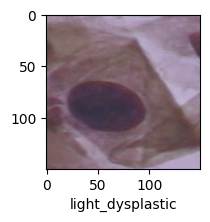

In [ ]:
plot_sample(X_test,y_test_new,5)

In [ ]:
classes[y_class[5]]

'moderate_dysplastic'

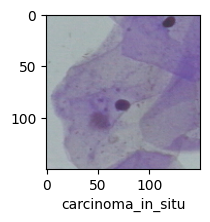

In [ ]:
plot_sample(X_train,y_test_new,1)

In [ ]:
classes[y_class[1]]

'severe_dysplastic'

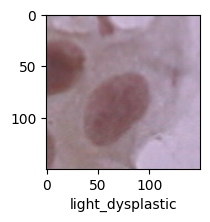

In [ ]:
plot_sample(X_train,y_test_new,0)

In [ ]:
classes[y_class[0]]

'light_dysplastic'

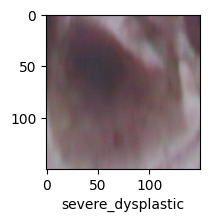

In [ ]:
plot_sample(X_train,y_test_new,11 )

In [ ]:
classes[y_class[11]]

'severe_dysplastic'

Shap

In [ ]:
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)
predicted_class

1/1 [==============================] - 0s 72ms/step


array([6, 1, 1, 3, 4, 5, 6])

In [ ]:
print(classification_report(y_test_new,y_class))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.71      0.63      0.67        19
           2       0.27      0.43      0.33         7
           3       0.92      0.86      0.89        14
           4       0.80      0.80      0.80         5
           5       1.00      0.86      0.92         7
           6       0.75      0.72      0.73        25

    accuracy                           0.72        92
   macro avg       0.73      0.72      0.72        92
weighted avg       0.74      0.72      0.73        92



In [ ]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[11,  0,  0,  0,  0,  0,  4],
       [ 0, 12,  6,  0,  0,  0,  1],
       [ 0,  3,  3,  1,  0,  0,  0],
       [ 1,  0,  0, 12,  0,  0,  1],
       [ 0,  1,  0,  0,  4,  0,  0],
       [ 0,  0,  0,  0,  1,  6,  0],
       [ 4,  1,  2,  0,  0,  0, 18]], dtype=int32)>

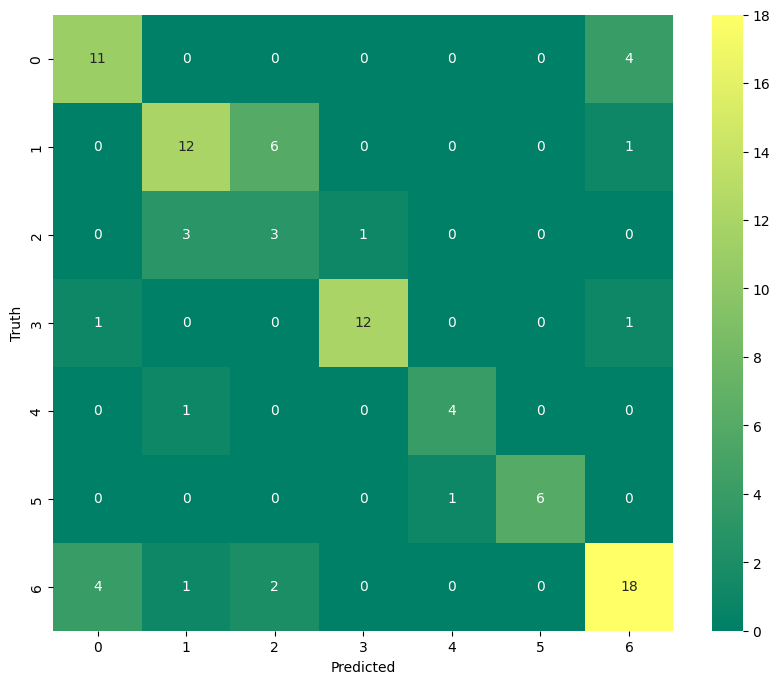

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='summer')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig(".png")


In [ ]:
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 7, figsize=(16, 15))
  axes = axes.flatten()

  # plot
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("Base reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')
  # plot image
  for k,v in images.items():
    ax = axes[int(k)]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"True: %s \nPredict: %s" % (classes[k], classes[pred_classes[k]]))
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()


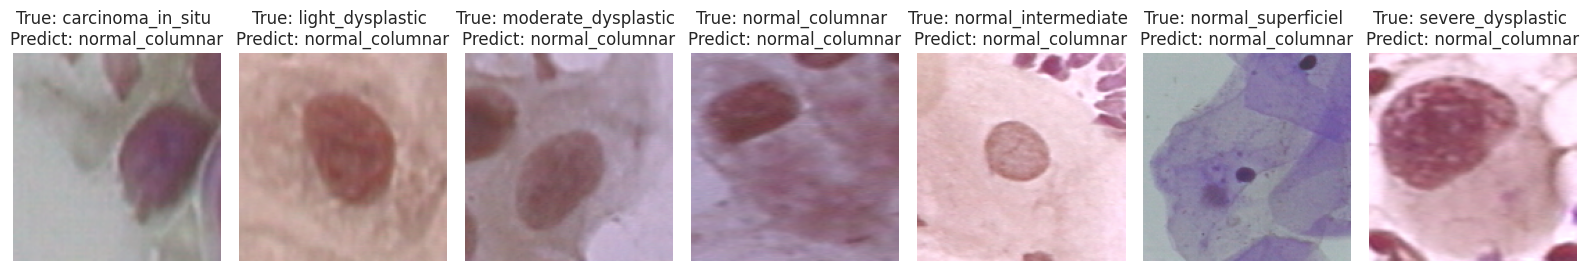

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_actual_predicted(images_dict, predicted_class)
plt.savefig('predited.png',dpi=300)


In [ ]:
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 9.2 MB/s eta 0:00:00


Shap

S

In [ ]:
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=classes)

explainer

In [ ]:
shap_values = explainer(x_test_each_class, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 1/7 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 3/7 [02:03<01:26, 21.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 4/7 [02:51<01:38, 32.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████▏  | 5/7 [03:36<01:14, 37.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 6/7 [04:19<00:39, 39.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 7/7 [05:04<00:00, 41.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 8it [05:47, 49.58s/it]


(7, 150, 150, 3, 5)

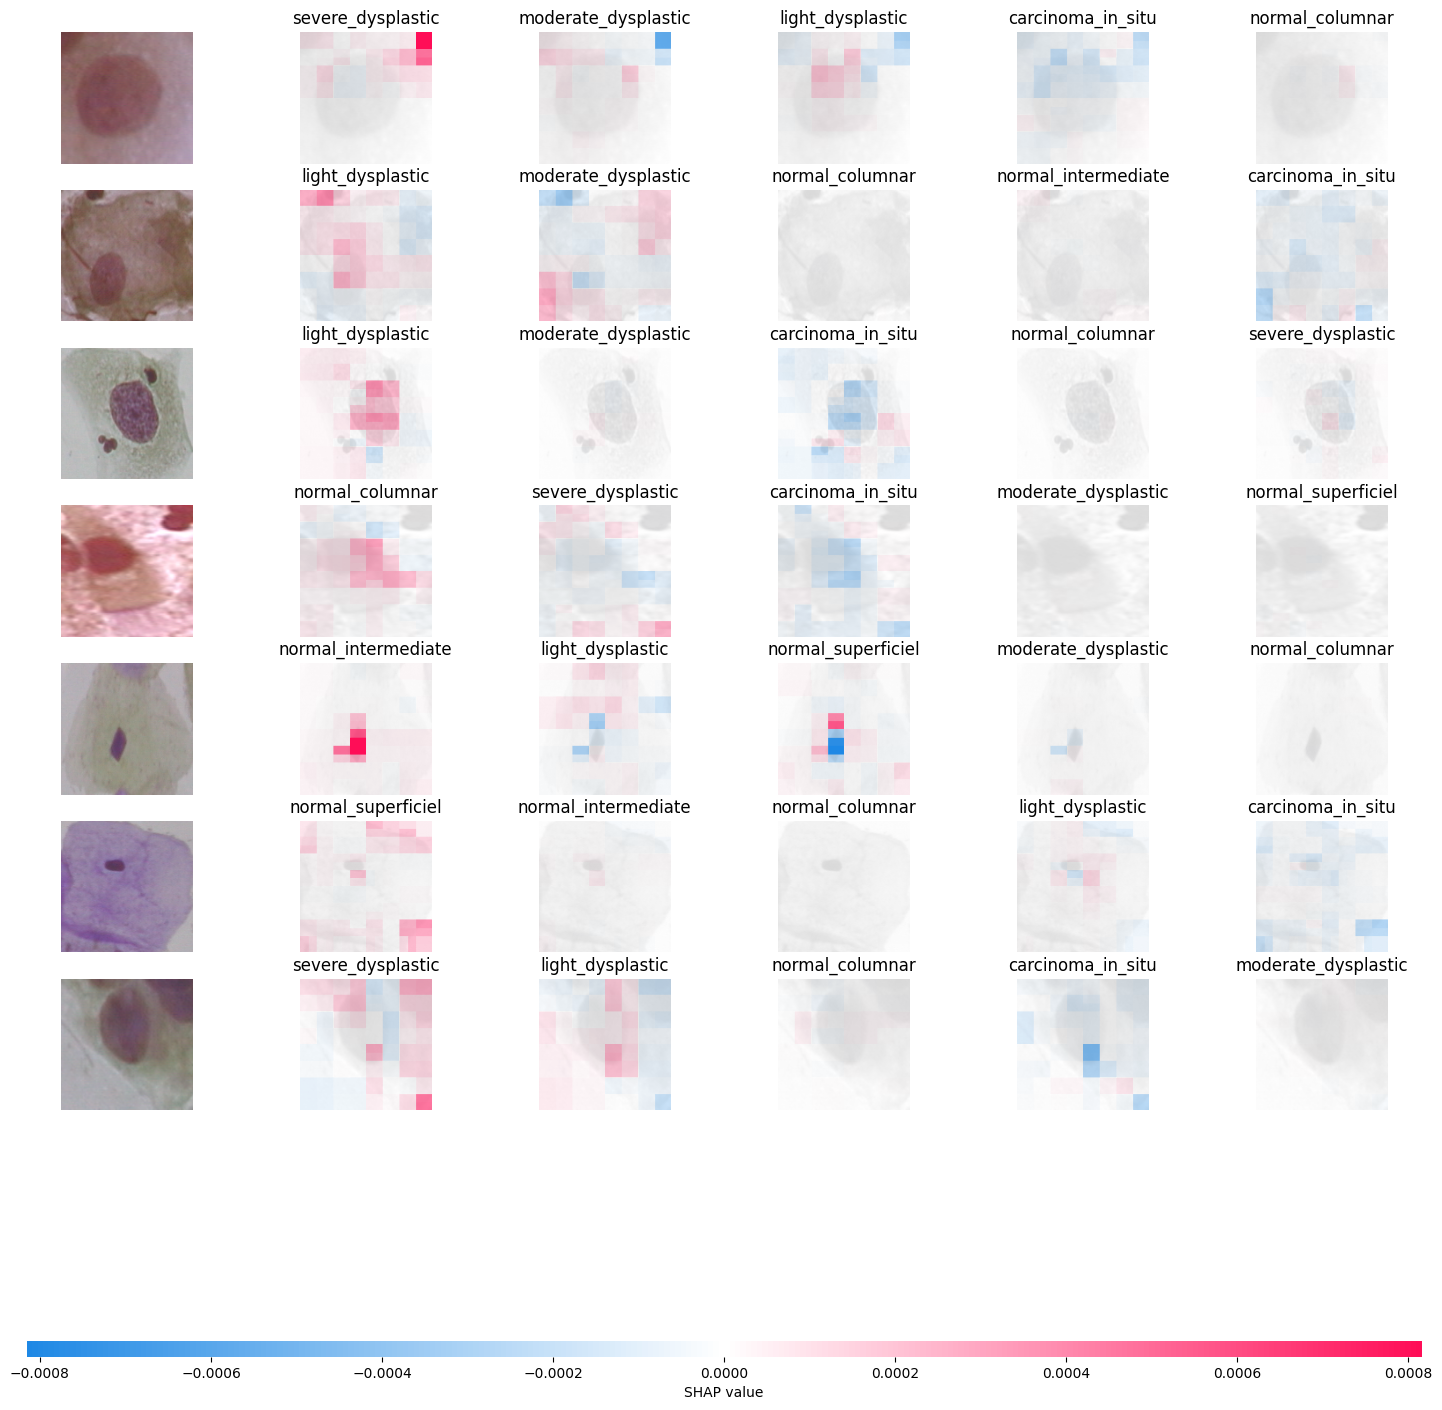

In [ ]:
shap.image_plot(shap_values)

Report,Confution Matrix

In [ ]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[11,  0,  0,  0,  0,  0,  4],
       [ 0, 12,  6,  0,  0,  0,  1],
       [ 0,  3,  3,  1,  0,  0,  0],
       [ 1,  0,  0, 12,  0,  0,  1],
       [ 0,  1,  0,  0,  4,  0,  0],
       [ 0,  0,  0,  0,  1,  6,  0],
       [ 4,  1,  2,  0,  0,  0, 18]], dtype=int32)>

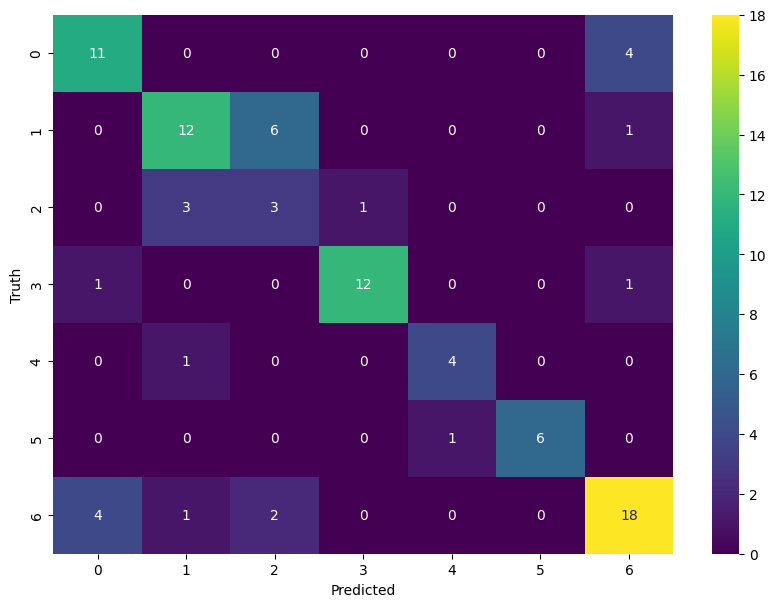

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')  # Use a valid colormap name
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig(".png")


# **vGG16**

In [ ]:
vgg=tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(150,150,3)
)
vgg.trainable=False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,Dropout


In [ ]:
model = Sequential()
model.add(vgg)
model.add(Conv2D(filters=512,
              kernel_size=(3, 3),
              padding='same',
              activation='relu',
              input_shape=(150,150,3),
              name='conv3_1'))
model.add(Conv2D(filters=512,
              kernel_size=(3, 3),
                  padding='same',
              activation='relu',
              name='conv3_2'))
model.add(Conv2D(filters=512,
              kernel_size=(3, 3),
                  padding='same',
              activation='relu',
              name='conv3_3'))

model.add(MaxPooling2D(pool_size=(2,2),
                   strides=(2,2),
                   name='max_pooling2d_3'))
model.add(Flatten(name='flatten'))
model.add(Dropout(0.5, name='dropout_4'))
model.add(Dense(4, activation='softmax', name='output'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv3_1 (Conv2D)            (None, 4, 4, 512)         2359808   
                                                                 
 conv3_2 (Conv2D)            (None, 4, 4, 512)         2359808   
                                                                 
 conv3_3 (Conv2D)            (None, 4, 4, 512)         2359808   
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 512)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                        

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("vgg16.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])
history = model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 7) and (None, 4) are incompatible


In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 7) and (None, 4) are incompatible


In [ ]:
EPOCHS=12
sns.set()
N = np.arange(0, EPOCHS)
plt.figure(figsize=(8,8))
plt.plot(N, model.history.history["loss"], label="train_loss")
plt.plot(N, model.history.history["val_loss"], label="val_loss")
plt.plot(N, model.history.history["accuracy"], label="train_acc")
plt.plot(N, model.history.history["val_accuracy"], label="val_acc")
plt.title("Training/Validation Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


KeyError: 'loss'

<Figure size 800x800 with 0 Axes>

predict


Shap

In [ ]:
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)
predicted_class

1/1 [==============================] - 2s 2s/step


array([3, 3, 3, 3, 3, 3, 3])

IndexError: index 4 is out of bounds for axis 0 with size 4

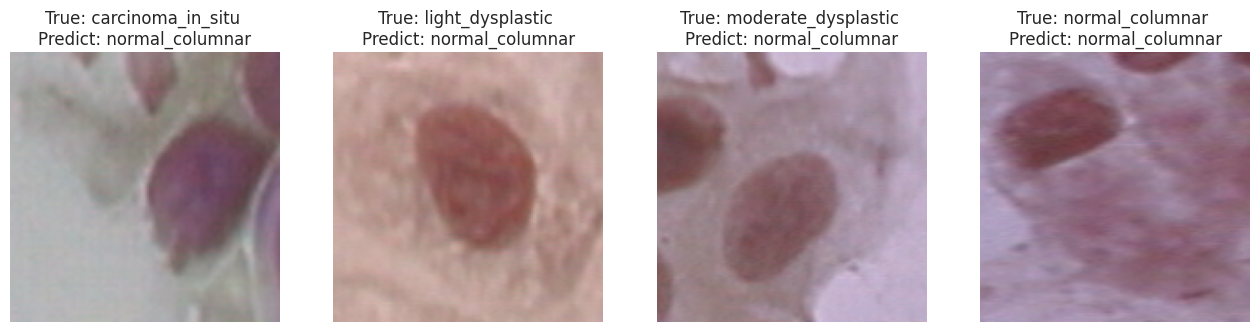

In [ ]:
plot_actual_predicted(images_dict, predicted_class)


In [ ]:
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=classes)

explainer

In [ ]:
shap_values = explainer(x_test_each_class, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 1/7 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 3/7 [00:25<00:20,  5.07s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 4/7 [00:37<00:24,  8.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████▏  | 5/7 [00:49<00:18,  9.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 6/7 [01:00<00:10, 10.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 7/7 [01:12<00:00, 10.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 8it [01:20, 11.45s/it]


(7, 150, 150, 3, 4)

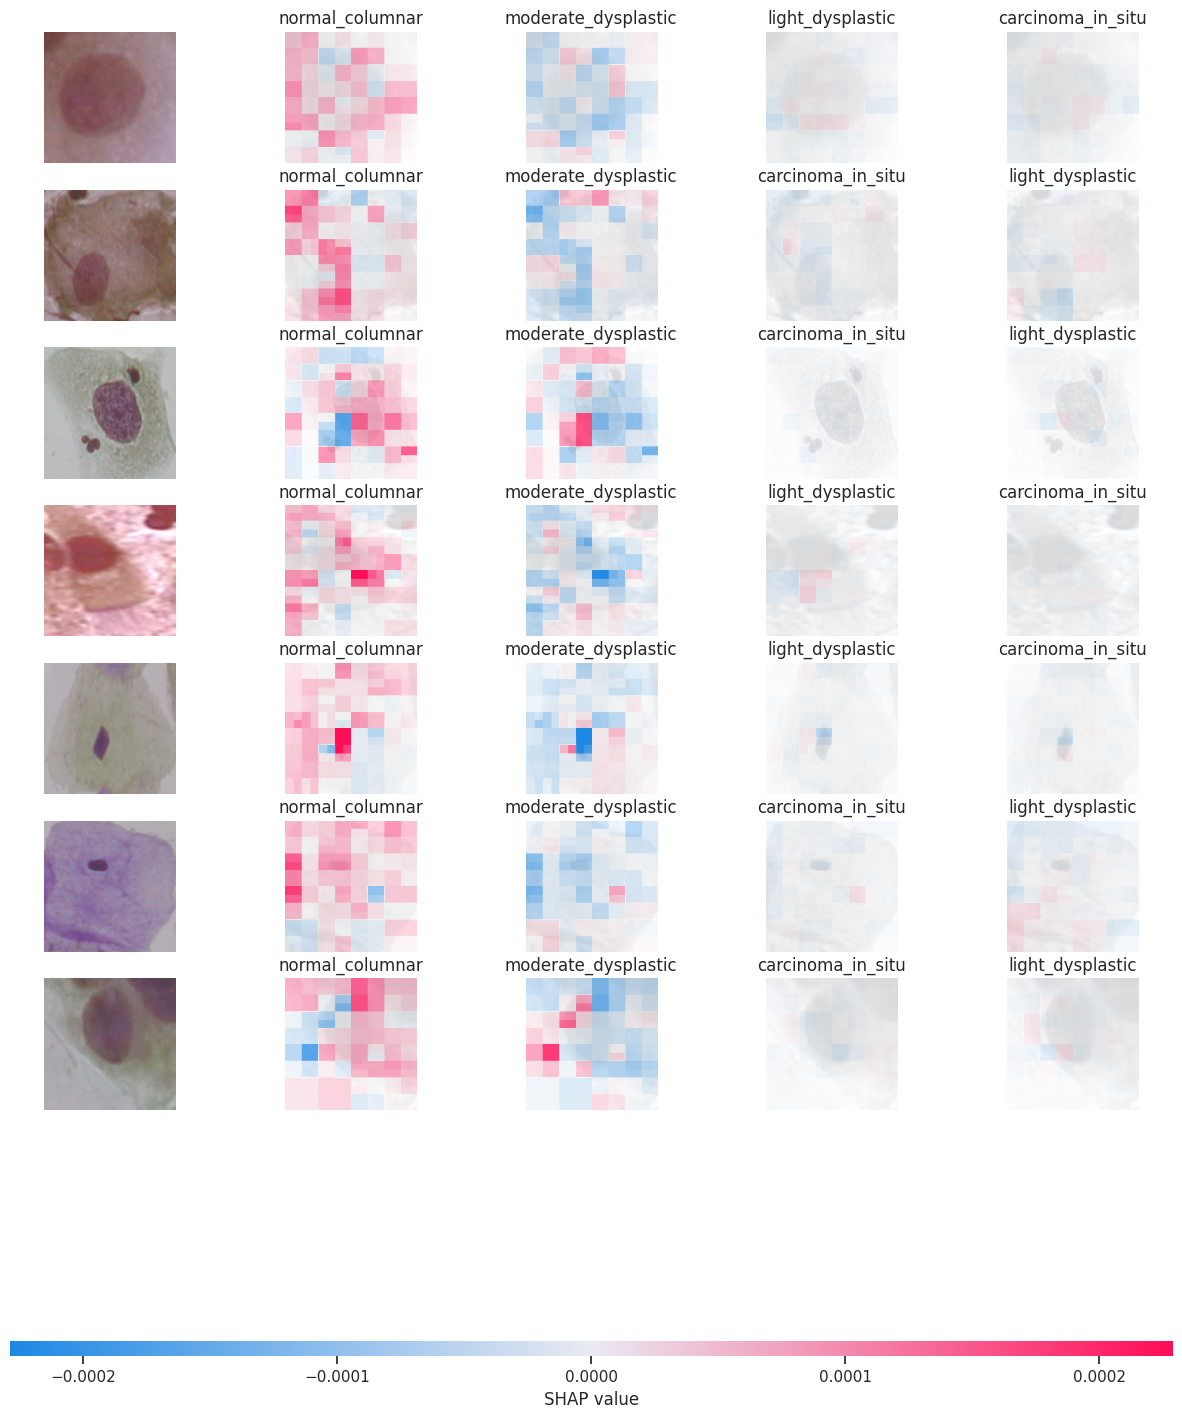

In [ ]:
shap.image_plot(shap_values)

In [ ]:
print(classification_report(y_test_new,y_class))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.71      0.63      0.67        19
           2       0.27      0.43      0.33         7
           3       0.92      0.86      0.89        14
           4       0.80      0.80      0.80         5
           5       1.00      0.86      0.92         7
           6       0.75      0.72      0.73        25

    accuracy                           0.72        92
   macro avg       0.73      0.72      0.72        92
weighted avg       0.74      0.72      0.73        92



In [ ]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[11,  0,  0,  0,  0,  0,  4],
       [ 0, 12,  6,  0,  0,  0,  1],
       [ 0,  3,  3,  1,  0,  0,  0],
       [ 1,  0,  0, 12,  0,  0,  1],
       [ 0,  1,  0,  0,  4,  0,  0],
       [ 0,  0,  0,  0,  1,  6,  0],
       [ 4,  1,  2,  0,  0,  0, 18]], dtype=int32)>

Text(91.25, 0.5, 'Truth')

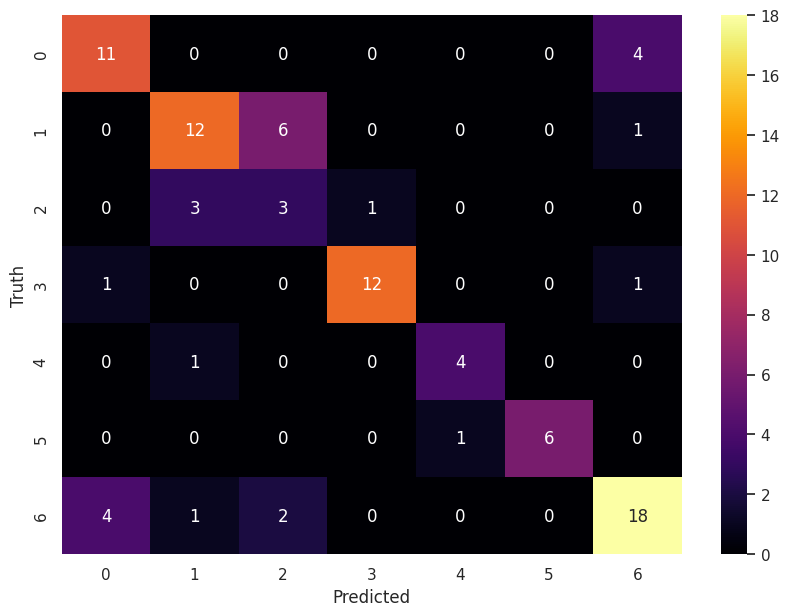

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='inferno')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
resnet= ResNet50(
    input_shape =(150,150,3), # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   #
)

In [ ]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])


In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet50.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 7) and (None, 4) are incompatible


In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.9968 - accuracy: 0.6916
Epoch 1: val_accuracy improved from -inf to 0.32653, saving model to vgg16.h5
83/83 [==============================] - 26s 216ms/step - loss: 0.9968 - accuracy: 0.6916 - val_loss: 14261.9658 - val_accuracy: 0.3265 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.8593
Epoch 2: val_accuracy did not improve from 0.32653
83/83 [==============================] - 15s 176ms/step - loss: 0.3884 - accuracy: 0.8593 - val_loss: 6.9270 - val_accuracy: 0.2823 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9311
Epoch 3: val_accuracy did not improve from 0.32653

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 [==============================] - 14s 175ms/step - loss: 0.2263 - accuracy: 0.9311 - val_loss: 2.9663 - val_accuracy: 0.2925 - lr: 0.0010
Epoch 4/12
83/83 [====

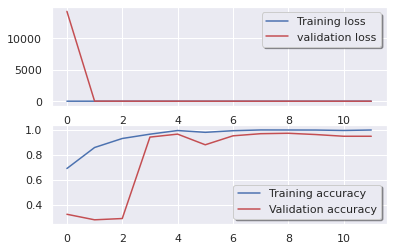

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.savefig("AUC.png")

In [ ]:
Y_pred=model.predict(X_test)


In [ ]:
y_class=[np.argmax(x) for x in Y_pred]


In [ ]:
print(classification_report(y_test_new,y_class))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        88
           1       0.94      0.98      0.96        50
           2       0.92      0.94      0.93        96
           3       0.97      1.00      0.98        93

    accuracy                           0.95       327
   macro avg       0.95      0.95      0.95       327
weighted avg       0.95      0.95      0.95       327



In [ ]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[78,  3,  7,  0],
       [ 0, 49,  1,  0],
       [ 3,  0, 90,  3],
       [ 0,  0,  0, 93]], dtype=int32)>

Text(66.5, 0.5, 'Truth')

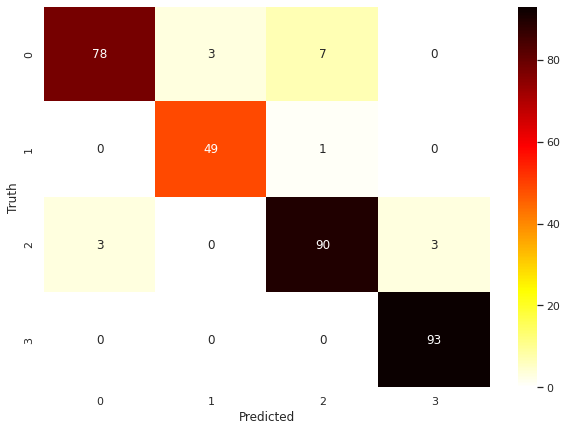

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='hot_r')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:

resnet= tf.keras.applications.resnet.ResNet101(
    input_shape =(224,224,3), # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   #
)

171446536/171446536 [==============================] - 8s 0us/step


In [ ]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet50.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.8737 - accuracy: 0.6939
Epoch 1: val_accuracy improved from -inf to 0.32653, saving model to resnet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 160s 692ms/step - loss: 0.8737 - accuracy: 0.6939 - val_loss: 4986.9326 - val_accuracy: 0.3265 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.8422
Epoch 2: val_accuracy improved from 0.32653 to 0.34694, saving model to resnet50.h5
83/83 [==============================] - 54s 651ms/step - loss: 0.4423 - accuracy: 0.8422 - val_loss: 5.9471 - val_accuracy: 0.3469 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8925
Epoch 3: val_accuracy did not improve from 0.34694
83/83 [==============================] - 47s 561ms/step - loss: 0.3456 - accuracy: 0.8925 - val_loss: 3.2514 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.6103 - accuracy: 0.8082
Epoch 4: val_accuracy did not improve from 0.34694

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 [=========

In [ ]:
Y_pred=model.predict(X_test)
y_class=[np.argmax(x) for x in Y_pred]

In [ ]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='hot_r')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
resnet= tf.keras.applications.vgg19.VGG19(
    input_shape =(224,224,3), # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   #
)

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet50.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 2.0749 - accuracy: 0.3042
Epoch 1: val_accuracy improved from -inf to 0.22449, saving model to resnet50.h5
83/83 [==============================] - 81s 683ms/step - loss: 2.0749 - accuracy: 0.3042 - val_loss: 1.2662 - val_accuracy: 0.2245 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 1.3439 - accuracy: 0.3348
Epoch 2: val_accuracy improved from 0.22449 to 0.24830, saving model to resnet50.h5
83/83 [==============================] - 41s 490ms/step - loss: 1.3439 - accuracy: 0.3348 - val_loss: 1.3486 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 1.2558 - accuracy: 0.3765
Epoch 3: val_accuracy improved from 0.24830 to 0.48299, saving model to resnet50.h5
83/83 [==============================] - 40s 483ms/step - loss: 1.2558 - accuracy: 0.3765 - val_loss: 1.1905 - val_accuracy: 0.4830 - lr: 0.0010
Epoch 4/12
83/83 [================